# Performative Prediction: A Case Study in Strategic Classification
# $k$ Groups Repond Slowly

Based on: https://github.com/zykls/whynot/tree/master/examples/dynamic_decisions

In [51]:
%load_ext autoreload
%autoreload 2

import pickle
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange
from sklearn.model_selection import KFold, StratifiedKFold

import whynot as wn
import whynot.gym as gym

import scripts.utils as utils

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
DEMO_N_GROUPS = 3

EPSILON_COL = r'$\varepsilon$'
VALUE_OF_EPSILON = f'Value of {EPSILON_COL}'

## Setting up the strategic classification environment

We use the [credit simulator](https://whynot.readthedocs.io/en/latest/simulators.html#credit-simulator), which is a strategic classification simulator based on the Kaggle [*Give Me Some Credit* dataset](https://www.kaggle.com/c/GiveMeSomeCredit).

In [53]:
envs = []
for _ in range(DEMO_N_GROUPS):
    env = gym.make('Credit-v0')
    env.seed(1)
    envs.append(env)

In [54]:
def get_data(datasets, combine=True):
    features, labels = zip(*((dataset['features'], dataset['labels']) for dataset in datasets))
    if combine:
        features = np.vstack(features)
        labels = np.hstack(labels)
    return features, labels

## Training a baseline logistic regression classifier

The state of the environment is a dataset consisting of (1) financial features of individuals, e.g. `DebtRatio`, and (2) a binary label indicating whether an individual experienced financial distress in the subsequent two years. 

In [55]:
base_datasets = (env.initial_state.values() for env in envs)
base_features, base_labels = get_data(base_datasets)
num_agents, num_features = base_features.shape
print(f"The dataset has {num_agents} agents and {num_features} features.")
print("Base rate:", base_labels.mean())

The dataset has 55071 agents and 11 features.
Base rate: 0.4552486789780465


Fit a logistic regression model to the data

In [56]:
l2_penalty = 1.0 / num_agents
baseline_theta = utils.fit_logistic_regression(base_features, base_labels, l2_penalty)
baseline_acc = ((base_features.dot(baseline_theta) > 0)  == base_labels).mean()
print(f"Baseline logistic regresion model accuracy: {100 * baseline_acc:.2f}%")

Baseline logistic regresion model accuracy: 72.07%


In [57]:
np.abs(baseline_theta).max()

1.7497371719683321

## Running repeated risk minimization

Using the credit environment, we simulate repeated retraining of the logistic regression model in response to
strategic distribution shift. We perform `num_iters` rounds. In each round:
1. We train an logistic regression classifier on the current set of features
2. The classifier is deployed via `env.step(theta)`
3. In the environment, individuals react strategically to the deployed classifier, and the environment returns a new set of fetaures for the next round.

The parameter `epsilon` changes the strength of the strategic response. Higher values of epsilon correspond to proportionally more strategic distribution shift. Each run is warm-started with the `baseline_theta` classifier computed without strategic response.

In [58]:
def update_start_stats_inplace(observations, theta, l2_penalty,
                               loss_start, acc_start, loss_groups_start, acc_groups_start,
                               fpr_groups_start, nr_groups_start):

    features_start, labels = get_data(observations)
    observations_groups = get_data(observations, combine=False)

    # Evaluate loss and accuracy on the new distribution
    loss_start.append(
        utils.evaluate_logistic_loss(features_start, labels, theta, l2_penalty))
    acc_start.append(
        ((features_start.dot(theta) > 0) == labels).mean()
    )

    # Evaluate per-group loss, accurcay, FPR and NR on the new distribution
    loss_groups_start.append(
        [utils.evaluate_logistic_loss(group_features, group_labels, theta, l2_penalty)
         for group_features, group_labels in zip(*observations_groups)])

    acc_groups_start.append(
        [((group_features.dot(theta) > 0) == group_labels).mean()
         for group_features, group_labels in zip(*observations_groups)])

    fpr_groups_start.append(
        [(
            ((group_features.dot(theta) > 0) & (group_labels == 0)).sum()  # FP
            / (group_labels == 0).sum())  # FP + TN
         for group_features, group_labels in zip(*observations_groups)])

    nr_groups_start.append(
        [(group_features.dot(theta) < 0).mean()
         for group_features, group_labels in zip(*observations_groups)])
    
    return features_start, labels, observations_groups

In [59]:
def build_world(num_groups, epsilon, random_state):
    
    base_env = gym.make('Credit-v0')
    kf = KFold(3, shuffle=True, random_state=random_state)
    group_splits = kf.split(base_env.env.state.features, base_env.env.state.labels)
    local_envs = []
    for _, indices in group_splits:
        env = gym.make('Credit-v0')
        env.config.epsilon = epsilon
        env.reset()
        
        env.env.state.features = base_env.env.state.features[indices, :]
        env.env.initial_state.features = base_env.env.initial_state.features[indices, :]
        env.config.base_state.features = base_env.config.base_state.features[indices, :]
        
        env.env.state.labels = base_env.env.state.labels[indices]
        env.env.initial_state.labels = base_env.env.initial_state.labels[indices]
        env.config.base_state.labels = base_env.config.base_state.labels[indices]
        
        env.reset()
        local_envs.append(env)

    return local_envs

In [60]:
def repeated_risk_minimization(epsilon, num_groups, num_steps, is_delayed, random_state):
    """Run repeated risk minimization for num_iters steps"""

    local_envs = build_world(num_groups, epsilon, random_state)

    
    # 1. Trach theta gap 
    # 2. Track loss and accuracy before/after updating model on new distribution
    # 3. Trach per-group loss, accurcay, FPR and NR before updating model on new distribution
    loss_start, loss_end, acc_start, acc_end, thetas, theta_gap = [], [], [], [], [], []
    loss_groups_start, loss_groups_end, acc_groups_start, fpr_groups_start, nr_groups_start = [], [], [], [], []

    observations = [env.initial_state.values() for env in local_envs]

    # Compute baseline classifier
    base_features, base_labels = get_data(observations)
    num_agents, num_features = base_features.shape
    l2_penalty = 1.0 / num_agents
    baseline_theta = utils.fit_logistic_regression(base_features, base_labels, l2_penalty)

    # Warm-start with baseline classifier
    theta = np.copy(baseline_theta)
    thetas.append(theta)
    
    # Set l2 penalty
    for env in local_envs:
        env.config.l2_penalty = l2_penalty
    
    update_start_stats_inplace(observations, theta, l2_penalty,
                                   loss_start, acc_start, loss_groups_start, acc_groups_start,
                                   fpr_groups_start, nr_groups_start)

    for step in trange(num_steps):
        
        # Update the latest group
        # and shift backward
        observations = observations[1:] + observations[0:1]
        local_envs = local_envs[1:] + local_envs[0:1]
        observations[-1], _, _, _ = local_envs[-1].step(theta)

        features_start, labels, observations_groups = update_start_stats_inplace(observations, theta, l2_penalty,
                                       loss_start, acc_start, loss_groups_start, acc_groups_start,
                                       fpr_groups_start, nr_groups_start)


        # Update classifier if (1) the algoirthm is RRM (not delayd);
        # or (2) it is the k-th iteration in Delayd RRM
        if not is_delayed or step % num_groups == 0:
            # Learn a new model on the induced distribution
            theta_new = utils.fit_logistic_regression(features_start, labels, l2_penalty,
                                                      theta_init=np.copy(theta))
        
        # Evaluate loss and accuracy on the strategic distribution after training
        loss_end.append(
            utils.evaluate_logistic_loss(features_start, labels, theta_new, l2_penalty)
        )
        acc_end.append(
            ((features_start.dot(theta_new) > 0) == labels).mean()
        )
        loss_groups_end.append(
            [utils.evaluate_logistic_loss(group_features, group_labels, theta_new, l2_penalty)
             for group_features, group_labels in zip(*observations_groups)])

        
        # Track distance between iterates
        theta_gap.append(np.linalg.norm(theta_new - theta))
        
        theta = np.copy(theta_new)
        
        thetas.append(theta)
        
    return (loss_start, loss_end, acc_start, acc_end, thetas, theta_gap,
            loss_groups_start, loss_groups_end, acc_groups_start, fpr_groups_start, nr_groups_start)

In [61]:
def run_rrm_experiment(epsilon_list, num_groups_list, num_iters, is_delayed, random_state):

    loss_starts, acc_starts, loss_ends, acc_ends, thetas_, theta_gaps = (defaultdict(dict), defaultdict(dict),
                                                                defaultdict(dict), defaultdict(dict),
                                                                defaultdict(dict), defaultdict(dict))
    loss_groups_starts, loss_groups_ends, acc_groups_starts, fpr_groups_starts, nr_groups_starts = (defaultdict(dict), defaultdict(dict),
                                                                                  defaultdict(dict), defaultdict(dict),
                                                                                  defaultdict(dict))

    for num_groups in num_groups_list:
        for _, epsilon in enumerate(epsilon_list):
            print(f'Running retraining for num_groups {num_groups} epsilon {epsilon:.2f}')

            (loss_start, loss_end, acc_start, acc_end, thetas, theta_gap,
             loss_groups_start, loss_groups_end, acc_groups_start,
             fpr_groups_start, nr_groups_start) = repeated_risk_minimization(epsilon, num_groups,
                                                                             num_iters, is_delayed,
                                                                             random_state)

            loss_starts[num_groups][epsilon] = loss_start
            loss_ends[num_groups][epsilon] = loss_end
            
            acc_starts[num_groups][epsilon] = acc_start
            acc_ends[num_groups][epsilon] = acc_end
            
            thetas_[num_groups][epsilon] = thetas
            theta_gaps[num_groups][epsilon] = theta_gap
            
            loss_groups_starts[num_groups][epsilon] = loss_groups_start
            loss_groups_ends[num_groups][epsilon] = loss_groups_end
            
            acc_groups_starts[num_groups][epsilon] = acc_groups_start
            fpr_groups_starts[num_groups][epsilon] = fpr_groups_start
            nr_groups_starts[num_groups][epsilon] = nr_groups_start
        
    return (loss_starts, acc_starts, loss_ends, acc_ends,
            thetas_, theta_gaps, loss_groups_starts, loss_groups_ends,
            acc_groups_starts, fpr_groups_starts, nr_groups_starts)

In [62]:
path = Path('./data.pckl')
epsilon_list = [1., 25., 75.]
num_groups_list = [3]
num_iters = 300
N_INITS = 10


if path.exists():
    with open(path, 'rb') as f:
        data = pickle.load(f)
        
else:
    data = defaultdict(dict)
    
    seed_rng = np.random.default_rng(42)
    seeds = [seed_rng.integers(low=0, high=2**31-1) for n in range(N_INITS)]
    
    for seed in seeds:
        print(f'\tseed={seed}')
            
        # RRM       k-Delayed RRM
        for mode in ['regular', 'delayed']:
            print(f'\t\tmode={mode}')
            is_delayed = (mode == 'delayed')
            (loss_starts, acc_starts, loss_ends, acc_ends, thetas_, theta_gaps,
             loss_groups_starts, loss_groups_ends,
             acc_groups_starts, fpr_groups_starts, nr_groups_starts) = run_rrm_experiment(epsilon_list,
                                                                                          num_groups_list,
                                                                                          num_iters,
                                                                                          is_delayed,
                                                                                          seed)
            print('\t\tDone!')



            data[seed][mode] = (loss_starts, acc_starts, loss_ends, acc_ends, thetas_, theta_gaps,
                                loss_groups_starts, loss_groups_ends,
                                acc_groups_starts, fpr_groups_starts, nr_groups_starts)

    print("Saving...")
    with open(path, 'wb') as f:
        pickle.dump(data, f)
    print("Done!")

	seed=191664963
		mode=regular
Running retraining for num_groups 3 epsilon 1.00


100%|██████████| 300/300 [00:06<00:00, 46.83it/s]


Running retraining for num_groups 3 epsilon 25.00


100%|██████████| 300/300 [00:08<00:00, 33.73it/s]


Running retraining for num_groups 3 epsilon 75.00


100%|██████████| 300/300 [00:20<00:00, 14.67it/s]


		Done!
		mode=delayed
Running retraining for num_groups 3 epsilon 1.00


100%|██████████| 300/300 [00:05<00:00, 54.78it/s]


Running retraining for num_groups 3 epsilon 25.00


100%|██████████| 300/300 [00:07<00:00, 41.30it/s]


Running retraining for num_groups 3 epsilon 75.00


100%|██████████| 300/300 [00:22<00:00, 13.19it/s]


		Done!
	seed=1662057957
		mode=regular
Running retraining for num_groups 3 epsilon 1.00


100%|██████████| 300/300 [00:06<00:00, 44.15it/s]


Running retraining for num_groups 3 epsilon 25.00


100%|██████████| 300/300 [00:09<00:00, 31.29it/s]


Running retraining for num_groups 3 epsilon 75.00


100%|██████████| 300/300 [00:26<00:00, 11.35it/s]


		Done!
		mode=delayed
Running retraining for num_groups 3 epsilon 1.00


100%|██████████| 300/300 [00:06<00:00, 48.57it/s]


Running retraining for num_groups 3 epsilon 25.00


100%|██████████| 300/300 [00:06<00:00, 44.89it/s]


Running retraining for num_groups 3 epsilon 75.00


100%|██████████| 300/300 [00:20<00:00, 14.44it/s]


		Done!
	seed=1405681631
		mode=regular
Running retraining for num_groups 3 epsilon 1.00


100%|██████████| 300/300 [00:07<00:00, 42.78it/s]


Running retraining for num_groups 3 epsilon 25.00


100%|██████████| 300/300 [00:09<00:00, 33.33it/s]


Running retraining for num_groups 3 epsilon 75.00


100%|██████████| 300/300 [00:21<00:00, 13.94it/s]


		Done!
		mode=delayed
Running retraining for num_groups 3 epsilon 1.00


100%|██████████| 300/300 [00:04<00:00, 70.94it/s]


Running retraining for num_groups 3 epsilon 25.00


100%|██████████| 300/300 [00:06<00:00, 45.01it/s]


Running retraining for num_groups 3 epsilon 75.00


100%|██████████| 300/300 [00:20<00:00, 14.51it/s]


		Done!
	seed=942484272
		mode=regular
Running retraining for num_groups 3 epsilon 1.00


100%|██████████| 300/300 [00:05<00:00, 55.90it/s]


Running retraining for num_groups 3 epsilon 25.00


100%|██████████| 300/300 [00:08<00:00, 34.09it/s]


Running retraining for num_groups 3 epsilon 75.00


100%|██████████| 300/300 [00:22<00:00, 13.64it/s]


		Done!
		mode=delayed
Running retraining for num_groups 3 epsilon 1.00


100%|██████████| 300/300 [00:04<00:00, 72.79it/s]


Running retraining for num_groups 3 epsilon 25.00


100%|██████████| 300/300 [00:06<00:00, 45.21it/s]


Running retraining for num_groups 3 epsilon 75.00


100%|██████████| 300/300 [00:21<00:00, 13.82it/s]


		Done!
	seed=929893137
		mode=regular
Running retraining for num_groups 3 epsilon 1.00


100%|██████████| 300/300 [00:06<00:00, 47.55it/s]


Running retraining for num_groups 3 epsilon 25.00


100%|██████████| 300/300 [00:08<00:00, 33.85it/s]


Running retraining for num_groups 3 epsilon 75.00


100%|██████████| 300/300 [00:36<00:00,  8.11it/s]


		Done!
		mode=delayed
Running retraining for num_groups 3 epsilon 1.00


100%|██████████| 300/300 [00:04<00:00, 69.06it/s]


Running retraining for num_groups 3 epsilon 25.00


100%|██████████| 300/300 [00:06<00:00, 44.30it/s]


Running retraining for num_groups 3 epsilon 75.00


100%|██████████| 300/300 [00:20<00:00, 14.79it/s]


		Done!
	seed=1843824992
		mode=regular
Running retraining for num_groups 3 epsilon 1.00


100%|██████████| 300/300 [00:06<00:00, 44.50it/s]


Running retraining for num_groups 3 epsilon 25.00


100%|██████████| 300/300 [00:13<00:00, 22.63it/s]


Running retraining for num_groups 3 epsilon 75.00


100%|██████████| 300/300 [02:09<00:00,  2.32it/s]


		Done!
		mode=delayed
Running retraining for num_groups 3 epsilon 1.00


100%|██████████| 300/300 [00:37<00:00,  7.93it/s]


Running retraining for num_groups 3 epsilon 25.00


100%|██████████| 300/300 [00:13<00:00, 21.57it/s]


Running retraining for num_groups 3 epsilon 75.00


100%|██████████| 300/300 [00:26<00:00, 11.28it/s]


		Done!
	seed=184566854
		mode=regular
Running retraining for num_groups 3 epsilon 1.00


100%|██████████| 300/300 [00:05<00:00, 55.57it/s]


Running retraining for num_groups 3 epsilon 25.00


100%|██████████| 300/300 [00:09<00:00, 32.29it/s]


Running retraining for num_groups 3 epsilon 75.00


100%|██████████| 300/300 [00:18<00:00, 15.95it/s]


		Done!
		mode=delayed
Running retraining for num_groups 3 epsilon 1.00


100%|██████████| 300/300 [00:04<00:00, 71.99it/s]


Running retraining for num_groups 3 epsilon 25.00


100%|██████████| 300/300 [00:31<00:00,  9.51it/s]


Running retraining for num_groups 3 epsilon 75.00


100%|██████████| 300/300 [00:27<00:00, 11.02it/s]


		Done!
	seed=1497586438
		mode=regular
Running retraining for num_groups 3 epsilon 1.00


100%|██████████| 300/300 [00:05<00:00, 51.37it/s]


Running retraining for num_groups 3 epsilon 25.00


100%|██████████| 300/300 [00:28<00:00, 10.45it/s]


Running retraining for num_groups 3 epsilon 75.00


100%|██████████| 300/300 [02:22<00:00,  2.11it/s]


		Done!
		mode=delayed
Running retraining for num_groups 3 epsilon 1.00


100%|██████████| 300/300 [00:04<00:00, 70.41it/s]


Running retraining for num_groups 3 epsilon 25.00


100%|██████████| 300/300 [00:09<00:00, 31.24it/s]


Running retraining for num_groups 3 epsilon 75.00


100%|██████████| 300/300 [01:15<00:00,  3.96it/s]


		Done!
	seed=432652533
		mode=regular
Running retraining for num_groups 3 epsilon 1.00


100%|██████████| 300/300 [00:35<00:00,  8.36it/s]


Running retraining for num_groups 3 epsilon 25.00


100%|██████████| 300/300 [00:18<00:00, 16.12it/s]


Running retraining for num_groups 3 epsilon 75.00


100%|██████████| 300/300 [03:55<00:00,  1.27it/s]


		Done!
		mode=delayed
Running retraining for num_groups 3 epsilon 1.00


100%|██████████| 300/300 [00:10<00:00, 28.84it/s]


Running retraining for num_groups 3 epsilon 25.00


100%|██████████| 300/300 [00:09<00:00, 32.46it/s]


Running retraining for num_groups 3 epsilon 75.00


100%|██████████| 300/300 [00:58<00:00,  5.12it/s]


		Done!
	seed=202244314
		mode=regular
Running retraining for num_groups 3 epsilon 1.00


100%|██████████| 300/300 [00:27<00:00, 10.79it/s]


Running retraining for num_groups 3 epsilon 25.00


100%|██████████| 300/300 [00:25<00:00, 11.84it/s]


Running retraining for num_groups 3 epsilon 75.00


100%|██████████| 300/300 [01:28<00:00,  3.40it/s]


		Done!
		mode=delayed
Running retraining for num_groups 3 epsilon 1.00


100%|██████████| 300/300 [00:11<00:00, 26.35it/s]


Running retraining for num_groups 3 epsilon 25.00


100%|██████████| 300/300 [00:17<00:00, 17.25it/s]


Running retraining for num_groups 3 epsilon 75.00


100%|██████████| 300/300 [00:22<00:00, 13.63it/s]


		Done!
Saving...
Done!


In [63]:
def create_long_df(tg, col, as_str=('epsilon', 'num_groups'), with_group=False, is_training_step=False):
    if not with_group:
        df = pd.DataFrame([{col: val, 'step': step, 'epsilon': epsilon, 'num_groups': num_groups}
                             for num_groups, d_eps_gap in tg.items()
                             for epsilon, gaps in d_eps_gap.items()
                             for step, val in enumerate(gaps[::num_groups if is_training_step else 1])])
    else:
        df = pd.DataFrame([{col: val, 'step': step, 'epsilon': epsilon, 'group_num': num_groups-group_num, 'num_groups': num_groups}
                             for num_groups, d_eps_grp_gap in tg.items()
                             for epsilon, d_grp_gaps in d_eps_grp_gap.items()
                             for step, gaps in enumerate(d_grp_gaps)
                             for group_num, val in enumerate(gaps[::num_groups if is_training_step else 1])])

    for c in as_str:
        df[c] = df[c].astype(str)

    return df

In [70]:
theta_gaps_dfs = []
acc_starts_dfs = []
nr_groups_start_dfs = []

for random_seed in data.keys():

    (loss_starts, acc_starts, loss_ends, acc_ends, thetas_, theta_gaps,
     loss_groups_starts, loss_groups_ends,
     acc_groups_starts, fpr_groups_starts, nr_groups_starts) = data[random_seed]['regular']

    (dloss_starts, dacc_starts, dloss_ends, dacc_ends, dthetas_, dtheta_gaps,
     dloss_groups_starts, dloss_groups_ends,
     dacc_groups_starts, dfpr_groups_starts, dnr_groups_starts) = data[random_seed]['delayed']
    
    
    theta_gaps_dfs.append(pd.concat([create_long_df(theta_gaps, 'gap')
                                     .assign(Algorithm='RRM'),
                                     create_long_df(dtheta_gaps, 'gap', is_training_step=True)
                                     .assign(Algorithm='$k$-Delayed RRM')])
                          .rename({'epsilon': EPSILON_COL}, axis=1)
                          .assign(random_seed=random_seed))
    
    
    
    acc_starts_dfs.append(pd.concat([create_long_df(acc_starts, 'Accuracy (%)')
                                     .assign(Algorithm='RRM'),
                                     create_long_df(dacc_starts, 'Accuracy (%)', is_training_step=False)
                                     .assign(Algorithm='$k$-Delayed RRM')])
                          .rename({'epsilon': VALUE_OF_EPSILON} , axis=1)
                          .assign(random_seed=random_seed))

    
    nr_groups_start_dfs.append(pd.concat([create_long_df(nr_groups_starts, 'Negative Rate (%)',
                                                         as_str=('epsilon', 'num_groups', 'group_num'), with_group=True)
                                          .assign(Algorithm='RRM'),
                                          create_long_df(dnr_groups_starts, 'Negative Rate (%)',
                                                         as_str=('epsilon', 'num_groups', 'group_num'), with_group=True)
                                          .assign(Algorithm='$k$-Delayed RRM')])
                               .rename({'epsilon': EPSILON_COL, 'group_num': 'Group'}, axis=1)
                               .assign(random_seed=random_seed))

    
theta_gaps_df = pd.concat(theta_gaps_dfs)
acc_starts_df = pd.concat(acc_starts_dfs)
nr_groups_start_df = pd.concat(nr_groups_start_dfs)

acc_starts_df['Accuracy (%)'] *= 100
nr_groups_start_df['Negative Rate (%)'] *= 100

## Visualization

### Convergence

/Users/shlomi/.local/share/virtualenvs/performative-prediction-stateful-world-Ne0_ixYe/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
No handles with labels found to put in legend.


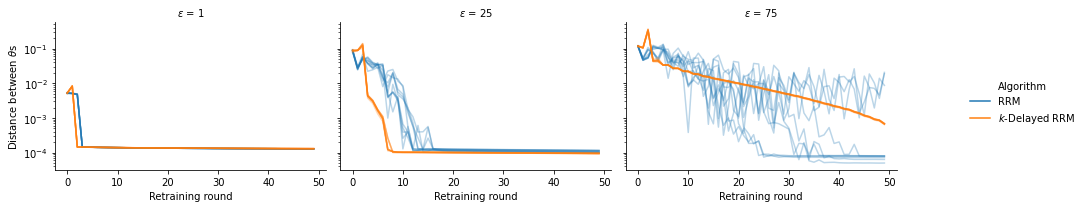

In [76]:
gap_data = theta_gaps_df[(theta_gaps_df[EPSILON_COL].isin(['1.0', '25.0', '75.0']))
                         & (theta_gaps_df['num_groups'] == '3')
                         & (theta_gaps_df['step'] < 50)]

gap_data.loc[:, EPSILON_COL] = gap_data[EPSILON_COL].str[:-2]

gap_data = gap_data.reset_index(drop=True)

g = sns.relplot(x='step', y='gap',
            # style='Algorithm',
            hue='Algorithm',
            col=EPSILON_COL,
            estimator=None, units='random_seed', alpha=.3,
            height=3, aspect=1.5,
            kind='line', data=gap_data)

g.set(yscale='log',
      xlabel='Retraining round',
      ylabel=r'Distance between $\theta$s')


plt.legend(loc='center left', bbox_to_anchor=(1.55, 0.5), frameon=False)
plt.tight_layout()
plt.savefig(f'./figures/convergence.png', dpi=300)

### Institution Utility

/Users/shlomi/.local/share/virtualenvs/performative-prediction-stateful-world-Ne0_ixYe/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
No handles with labels found to put in legend.


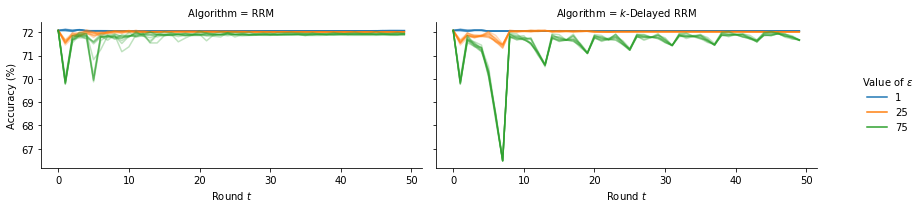

In [77]:
acc_data = acc_starts_df[((acc_starts_df['num_groups'] == '3')
                         & (acc_starts_df[VALUE_OF_EPSILON].isin(['1.0', '25.0', '75.0']))
                         & (acc_starts_df['step'] < 50))]

acc_data[VALUE_OF_EPSILON] = acc_data[VALUE_OF_EPSILON].str[:-2]

acc_data = acc_data.reset_index(drop=True)


g = sns.relplot(x='step', y='Accuracy (%)',
            hue=VALUE_OF_EPSILON,
            # style=VALUE_OF_EPSILON,
            col='Algorithm',
            estimator=None, units='random_seed', alpha=.3,
            height=3, aspect=2,  
            kind='line', data=acc_data)


g.set(xlabel='Round $t$')

plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5), frameon=False)
plt.tight_layout()
plt.savefig(f'./figures/institution-utility-start.png', dpi=300)

### Per-Group Analysis

No handles with labels found to put in legend.


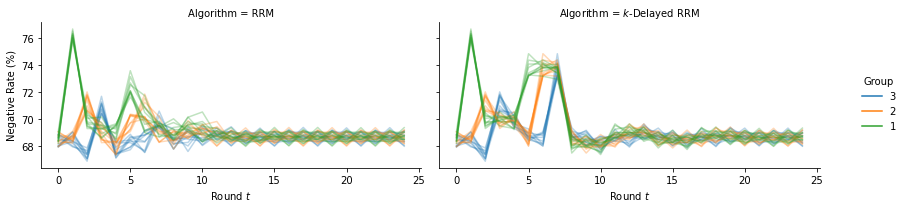

In [78]:
nr_group_start_data = nr_groups_start_df[((nr_groups_start_df['num_groups'] == '3')
                                         & (nr_groups_start_df['step'] < 25)
                                         & (nr_groups_start_df[r'$\varepsilon$'].isin(['25.0'])))]
                                         
nr_group_start_data = nr_group_start_data.reset_index(drop=True)

    
g = sns.relplot(x='step', y='Negative Rate (%)',
            hue='Group', 
            # style='Group',
            col='Algorithm',
            estimator=None, units='random_seed', alpha=.3,
            height=3, aspect=2,  
            kind='line', data=nr_group_start_data)

                                         
g.set(xlabel='Round $t$')

plt.legend(loc='center left', bbox_to_anchor=(1.15, 0.5), frameon=False)
plt.tight_layout()
plt.savefig(f'./figures/pergroup-nr-start.png', dpi=300)

In [79]:
for algorithm in ['RRM', '$k$-Delayed RRM']:
    nr_delayed_begining_data = nr_group_start_data[(nr_group_start_data['step'] < 10)
                                            & (nr_group_start_data['Algorithm'] == algorithm)]
    nr_cum_goupby = nr_delayed_begining_data.groupby('Group')['Negative Rate (%)'].sum()
    
    print(f'{algorithm} - Group Adventage Ration:',
          (nr_cum_goupby/nr_cum_goupby.iloc[2]).round(4))
    print()

RRM - Group Adventage Ration: Group
1    1.0252
2    1.0092
3    1.0000
Name: Negative Rate (%), dtype: float64

$k$-Delayed RRM - Group Adventage Ration: Group
1    1.0265
2    1.0107
3    1.0000
Name: Negative Rate (%), dtype: float64

